# Dense Layer class

In [95]:
class DenseLayer:
    def __init__(self, input_dim, output_dim, initialization='he'):
        """
        The initialize_parameters() function initializes the weights and biases of a neural network layer using xavier initialization
        """
        #X
        self.input_X = None
        #Z
        self.output_Z = None

        self.gradient_weights_dw = None
        self.gradient_bias_db = None
        # for printing purposes
        self.gradient_output_dz = None
        self.gradient_input_dx = None
        self.bias = np.zeros((1, output_dim))

        if initialization == 'he':
            self.weight_matrix = np.random.randn(input_dim, output_dim) * np.sqrt(2/input_dim)
        elif initialization == 'xavier':
            limit = np.sqrt(6 / (input_dim + output_dim))
            self.weight_matrix = np.random.uniform(-limit, limit, (input_dim, output_dim))

    def forward_pass(self, input_data):
        """
        Z = WX + b.
        """
        self.input_X = input_data
        self.output_Z = np.dot(input_data, self.weight_matrix) + self.bias
        return self.output_Z


    def backward_pass(self, gradient_output_dZ, learning_rate):
        """
        Perform the backward pass and update weights and biases
        """
        self.gradient_output_dz = gradient_output_dZ   # For printing

        self.gradient_bias_db = np.sum(gradient_output_dZ, axis=0, keepdims=True)
        self.gradient_weights_dw = np.dot(self.input_X.T, gradient_output_dZ)

        gradient_input_dX = np.dot(gradient_output_dZ, self.weight_matrix.T)
        self.gradient_input_dx = gradient_input_dX  # For printing purposes

        return gradient_input_dX


# ReLU Activation

In [96]:
class RELU:
    def __init__(self):
        self.input_Z = None
        self.gradient_of_RELU = None


    def forward_pass(self, input_Z):
        self.input_Z = input_Z
        return np.maximum(0, input_Z)

    def backward_pass(self, gradient_output,lr):

        self.gradient_of_RELU = (self.input_Z > 0).astype(float)
        return gradient_output * self.gradient_of_RELU

# Batch Normalization

In [97]:
class BatchNormalization:
    def __init__(self, input_dimension, momentum=0.9, epsilon=1e-8):
        self.mean_of_the_minibatch = None
        self.variance_of_the_minibatch = None
        self.epsilon = epsilon
        self.momentum = momentum
        self.beta_factor = np.zeros((1, input_dimension))

        self.gamma_factor = np.ones((1, input_dimension))

        self.input_Z = None
        self.normalized_input_Z = None

        self.mean_running = np.zeros((1, input_dimension))
        self.variance_running = np.ones((1, input_dimension))

        self.output_data = None


    def forward_pass(self, input_data, training=True):
        # Store input data
        self.input_Z = input_data

        if training:
            # Compute batch mean and variance

            self.mean_of_the_minibatch = np.mean(input_data, axis=0, keepdims=True)
            self.variance_of_the_minibatch = np.var(input_data, axis=0, keepdims=True)

            # Normalize input based on the batch statistics

            self.normalized_input = (input_data - self.mean_of_the_minibatch)/(np.sqrt(self.variance_of_the_minibatch + self.epsilon))

            # Update running statistics

            self.mean_running = (self.momentum * self.mean_running) + ((1 - self.momentum) * self.mean_of_the_minibatch)
            self.variance_running = (self.momentum * self.variance_running) + ((1 - self.momentum) * self.variance_of_the_minibatch)
        else:
            # Use running statistics during inference

            self.normalized_input = (input_data - self.mean_of_the_minibatch)/(np.sqrt(self.variance_of_the_minibatch + self.epsilon))

        # Apply scale (gamma) and shift (beta) in two steps
        self.output_data = self.gamma_factor * self.normalized_input + self.beta_factor
        return self.output_data

    def compute_gradient_variance(self, gradient_input, batch_size):
        # Calculate gradient with respect to variance in smaller steps
        A = self.input_Z - self.mean_of_the_minibatch
        B = (self.variance_of_the_minibatch + self.epsilon) ** -1.5

        gradient_variance = np.sum(gradient_input * A * -0.5 * B, axis=0)
        return gradient_variance

    def compute_gradient_mean(self, gradient_input, gradient_variance, batch_size):
        # Calculate gradient with respect to the mean
        A = np.sqrt(self.variance_of_the_minibatch + self.epsilon)
        C = gradient_input * -1.0
        gradient_mean = np.sum(C / A, axis=0)
        J = -2.0 * (self.input_Z - self.mean_of_the_minibatch)

        gradient_mean = gradient_mean + (gradient_variance * np.mean(J, axis=0))
        return gradient_mean

    def update_parameters(self, learning_rate, gradient_beta, gradient_gamma):
        # Update gamma and beta in separate steps
        self.gamma_factor = self.gamma_factor - learning_rate * gradient_gamma
        self.beta_factor = self.beta_factor - learning_rate * gradient_beta

    def compute_gradient_input(self, gradient_variance, gradient_mean, gradient_normalized_input, batch_size):
        # Calculate input gradient in parts
        V = (gradient_variance * 2.0 * (self.input_Z - self.mean_of_the_minibatch)) / batch_size
        A = (gradient_normalized_input / np.sqrt(self.variance_of_the_minibatch + self.epsilon))
        D = (gradient_mean / batch_size)

        gradient_input = A + V + D
        return gradient_input

    def backward_pass(self, gradient_output, learning_rate):
        batch_size = self.input_Z.shape[0]

        # Compute gradients for gamma, beta, and normalized input
        gradient_beta = np.sum(gradient_output, axis=0)
        gradient_gamma = np.sum(gradient_output * self.normalized_input, axis=0)
        gradient_normalized_input = gradient_output * self.gamma_factor

        # Compute gradients for variance and mean
        gradient_variance = self.compute_gradient_variance(gradient_normalized_input, batch_size)
        gradient_mean = self.compute_gradient_mean(gradient_normalized_input, gradient_variance, batch_size)

        # Compute gradient with respect to input
        gradient_input = self.compute_gradient_input(gradient_variance, gradient_mean, gradient_normalized_input, batch_size)

        # Update parameters
        self.update_parameters(learning_rate, gradient_beta, gradient_gamma)

        return gradient_input


# Dropout Regularization

In [98]:
class Dropout:
  def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        #to identify which neurons to drop
        self.mask_vector = None
        self.training_mode = True  # Whether the layer is in training mode

  def forward_pass(self, input_data, training=True):

        self.training_mode = training
        if self.training_mode:
            # Create a binary mask with 0s and 1s (1 where the neuron is kept, 0 where it is dropped)
            self.mask_vector = np.random.binomial(1, 1 - self.dropout_rate, size=input_data.shape)

            output_data = (input_data * self.mask_vector) / ((1 - self.dropout_rate))
        else:
            # No dropout applied during inference
            output_data = input_data
        return output_data

  def backward_pass(self, gradient_output,lr):
        if self.training_mode:
            # Backpropagate the gradient through the dropout mask
            return (gradient_output * self.mask_vector) / ((1 - self.dropout_rate))
        else:
            # No dropout applied during inference, return gradient as-is
            return gradient_output

# Adam Optimizer

In [99]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, first_momentum_decay=0.9, second_momentum_decay=0.999, epsilon=1e-8):
        self.alpha_lr = learning_rate
        self.beta_1 = first_momentum_decay
        self.beta_2 = second_momentum_decay

        self.mean_avg_bias = {}
        self.mean_avg_sq_bias = {}
        self.mean_avg_wt = {}
        self.mean_avg_sq_wt = {}
        self.eps = epsilon
        self.timestep_counter = 0


    def initialization(self, layer):
        if layer not in self.mean_avg_wt:
            self.mean_avg_bias[layer] = np.zeros_like(layer.bias)
            self.mean_avg_sq_bias[layer] = np.zeros_like(layer.bias)
            self.mean_avg_wt[layer] = np.zeros_like(layer.weight_matrix)
            self.mean_avg_sq_wt[layer] = np.zeros_like(layer.weight_matrix)


    def compute_average_moving(self, gradient, momentum_average, beta_factor):
        A = beta_factor * momentum_average

        B = (1 - beta_factor) * gradient
        C = A + B
        return C

    def compute_corrected_bias(self, momentum_avg, beta_factor):
        A=beta_factor ** self.timestep_counter
        C = 1 - A
        D = momentum_avg / C
        return D

    def compute_weight_update(self, layer, weight_dx, bias_dx):
        # Perform weight and bias updates
        layer.bias =layer.bias - bias_dx

        layer.weight_matrix =layer.weight_matrix - weight_dx
        #print(f"AFTER...{layer.weight_matrix}...")


    def compute_updated_weight(self, corrected_w, corrected_sq_w):
        # Compute the weight update using Adam's update rule
        A = self.alpha_lr * corrected_w
        X=np.sqrt(corrected_sq_w)
        B = X + self.eps
        weight_update = A / B
        return weight_update

    def compute_updated_bias(self, corrected_b, corrected_sq_b):
        # Compute the bias update using Adam's update rule
        X = self.alpha_lr * corrected_b
        Y = np.sqrt(corrected_sq_b) + self.eps
        bias_update = X / Y
        return bias_update


    def update(self, layer):
        # Ensure moments are initialized for this layer
        self.initialization(layer)

        # Increment time step counter
        self.timestep_counter=self.timestep_counter + 1

        # Fetch gradients from the layer
        gradient_bias = layer.gradient_bias_db

        gradient_wt = layer.gradient_weights_dw



        self.mean_avg_bias[layer] = self.compute_average_moving(gradient_bias, self.mean_avg_bias[layer], self.beta_1)
        X=np.square(gradient_bias)
        self.mean_avg_sq_bias[layer] = self.compute_average_moving(X, self.mean_avg_sq_bias[layer], self.beta_2)
        Y=np.square(gradient_wt)
        self.mean_avg_sq_wt[layer] = self.compute_average_moving(Y, self.mean_avg_sq_wt[layer], self.beta_2)
        self.mean_avg_wt[layer] = self.compute_average_moving(gradient_wt, self.mean_avg_wt[layer], self.beta_1)


        # --- Apply bias correction ---
        corr_bias = self.compute_corrected_bias(self.mean_avg_bias[layer], self.beta_1)
        corr_sq_bias = self.compute_corrected_bias(self.mean_avg_sq_bias[layer], self.beta_2)

        corr_sq_wt = self.compute_corrected_bias(self.mean_avg_sq_wt[layer], self.beta_2)
        corr_wt = self.compute_corrected_bias(self.mean_avg_wt[layer], self.beta_1)


        # --- Compute updates for weights and biases ---
        bias_change = self.compute_updated_bias(corr_bias, corr_sq_bias)

        weight_change = self.compute_updated_weight(corr_wt, corr_sq_wt)

        # --- Update weights and biases in the layer ---
        self.compute_weight_update(layer, weight_change, bias_change)

# Softmax Classification

In [100]:
class Softmax:
    def __init__(self):
        self.output_data = None
        self.input_data = None
        self.input_gradient=None
        self.output_gradient=None

    def shift(self,X):
        return (X - (np.max(X, axis=1, keepdims=True)))

    def forward_pass(self, input_X):
        # Shift input by subtracting the max value for numerical stability
        U=self.shift(input_X)

        # Compute softmax probabilities
        softmax_output = np.exp(U) / (np.sum(np.exp(U), axis=1, keepdims=True))
        self.output_data = softmax_output
        self.input_data = input_X
        return softmax_output

    def compute(self,output_gradient):
        return (output_gradient - (np.sum((output_gradient * self.output_data), axis=1, keepdims=True)))

    def backward_pass(self, output_gradient, learning_rate=0.5):
        # Gradient of the softmax function
        gradient_input = self.output_data * (output_gradient - (np.sum((output_gradient * self.output_data), axis=1, keepdims=True)))

        self.input_gradient=gradient_input
        self.output_gradient=output_gradient
        return gradient_input

# Categorical Cross Entropy Loss

In [101]:
class CategoricalCrossEntropyLoss:
    EPS=1e-12
    def __init__(self):
        self.original_labels = None
        self.pred_prob = None
        self.mean_batch_loss=None
        self.output_gradient=None

    def forward_pass(self, predicted_prob, original_labels):
        self.pred_prob = predicted_prob
        self.original_labels = original_labels

        # Clip predicted probabilities to avoid log(0) and divide-by-zero errors
        clipped_prob = np.clip(predicted_prob, 1e-12, 1.0)

        # Calculate categorical cross-entropy
        loss_of_the_batch = -np.sum((original_labels * np.log(clipped_prob)), axis=1)
        self.mean_batch_loss = np.mean(loss_of_the_batch)

        return self.mean_batch_loss

    def backward_pass(self):
      self.output_gradient = self.pred_prob - self.original_labels
      return self.output_gradient

# Neural Network

In [102]:
class NeuralNetwork:
    def __init__(self, number_of_layers, neurons_in_each_layer, input_dimensions, number_of_classes, dropout_rate=0.1,learning_rate=0.001):
        #This is the architecture class
        #the number of features in the input
        self.input_features = input_dimensions
        #For classification,the number of labels to classify
        self.number_of_classes = number_of_classes
        #total number of layers which include input+hidden layers
        self.number_of_total_layers = number_of_layers
        #an array to hold the number of neurons in each layer
        self.number_of_neurons_in_each_layer = neurons_in_each_layer

        #set a dropout rate
        self.dropout_rate = dropout_rate
        self.learning_rate=learning_rate
        #store all the layers in this arr
        self.all_layers = []

        # Automatically build the layers for classification problem
        self.build_the_network()

    def build_a_single_layer(self, input_dim, output_dim):
        dense_layer = DenseLayer(input_dim=input_dim, output_dim=output_dim)
        batchNormalization_layer = BatchNormalization(input_dimension=output_dim)
        activation_function_layer = RELU()
        dropout_layer = Dropout(dropout_rate=self.dropout_rate)

        return [dense_layer,batchNormalization_layer, activation_function_layer,dropout_layer]

    def build_the_hidden_network(self):
        number_of_previous_layer_neurons = self.input_features

        for index in range(self.number_of_total_layers):
            current_layer = self.build_a_single_layer(number_of_previous_layer_neurons, self.number_of_neurons_in_each_layer[index])
            number_of_previous_layer_neurons = self.number_of_neurons_in_each_layer[index]
            self.all_layers.extend(current_layer)
        return number_of_previous_layer_neurons

    def build_the_output_layer(self,number_of_previous_layer_neurons):
        self.all_layers.append(DenseLayer(input_dim=number_of_previous_layer_neurons, output_dim=self.number_of_classes))
        self.all_layers.append(Softmax())


    def build_the_network(self):
        number_of_previous_layer_neurons = self.build_the_hidden_network()

        #this is the final layer for which activation is different
        self.build_the_output_layer(number_of_previous_layer_neurons)


    def forward_pass(self, input_data, training=True):

        for l in self.all_layers:
            if isinstance(l, Dropout):
                input_data = l.forward_pass(input_data, training=training)
            else:
                input_data = l.forward_pass(input_data)
        return input_data

    def backward_pass(self, gradient_of_the_loss, learning_rate, optimizer):

        for layer in reversed(self.all_layers):
            gradient_of_the_loss = layer.backward_pass(gradient_of_the_loss, learning_rate)
            if isinstance(layer, DenseLayer):
                optimizer.update(layer)

    def train_the_network(self, X, true_labels, optimizer, loss_function, learning_rate):

        # Forward pass
        predicted_prob = self.forward_pass(X, training=True)

        # Compute loss
        loss_val = loss_function.forward_pass(predicted_prob, true_labels)

        # Backward pass
        gradient_of_the_loss = loss_function.backward_pass()
        self.backward_pass(gradient_of_the_loss, learning_rate, optimizer)

        return loss_val

    def predict(self, input_data):
        ans=self.forward_pass(input_data, training=False)
        return ans

    def get_weights(self):
        """
        Extract weights from all Dense layers in the network.
        """
        weights_list = []
        for layer in self.all_layers:
            if isinstance(layer, DenseLayer):
                # Store weights and biases as a dictionary for each DenseLayer
                weights_list.append({
                    'weights': layer.weight_matrix,
                    'biases': layer.bias
                })
        return weights_list

    def load_weights(self, weights):
        """
        Load weights into the layers of the neural network.
        """
        weight_index = 0
        for layer in self.all_layers:
            if isinstance(layer, DenseLayer):
                # Set weights and biases for the DenseLayer
                layer.weight_matrix = weights[weight_index]['weights']
                layer.bias = weights[weight_index]['biases']
                weight_index += 1

        print("Weights loaded successfully into the network.")

# Load the Dataset

In [103]:
from sklearn.preprocessing import MinMaxScaler
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np
import pickle


transform = transforms.ToTensor()

# load the training and testing dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# images now are in tensor format
train_images_tensor = train_data.data.numpy()
print(f"train images shape : {train_images_tensor.shape}")
train_images_reshaped = train_images_tensor.reshape(train_images_tensor.shape[0], 28 * 28)

test_images_tensor = test_data.data.numpy()
test_images_reshaped = test_images_tensor.reshape(test_images_tensor.shape[0], 28 * 28)

train_features = train_images_reshaped
test_features = test_images_reshaped

train_targets = train_data.targets.numpy()
test_targets = test_data.targets.numpy()

# Scale the data using StandardScaler
scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)
# Save the scaler to a file
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Split training data into training and validation sets
train_features, val_features, train_targets, val_targets = train_test_split(train_features, train_targets, test_size=0.2, random_state=42)

train images shape : (60000, 28, 28)


# Function to convert the labels to One-hot Encoded Labels

In [104]:
import numpy as np

def one_hot_encode(labels, num_classes):
    #creates an identity matrix
    identity_matrix = np.eye(num_classes)
    #changes the matrix according to labels
    one_hot_encoded_labels = identity_matrix[labels]
    return one_hot_encoded_labels

# Parameters for Neural Network

In [105]:
# Second Model Architecture
number_of_layers = 4
neurons_in_each_layer = [32,64,64,32]
input_dimensions = train_features.shape[1]
number_of_classes = 10
d_rate = 0.3  # Increase dropout to reduce overfitting
adam_learning_rate = 0.004
learning_rate = 0.005
number_of_epochs = 26  # Keep epochs consistent for fair comparison

# Convert the targets into one-hot encoded labels

In [106]:
# One-hot encoding the labels for training, validation, and test sets
train_targets_one_hot = one_hot_encode(train_targets, num_classes=number_of_classes)
val_targets_one_hot = one_hot_encode(val_targets, num_classes=number_of_classes)
test_targets_one_hot = one_hot_encode(test_targets, num_classes=number_of_classes)

# Neural Network Initialization

In [107]:
neural_network = NeuralNetwork(
    number_of_layers=number_of_layers,
    neurons_in_each_layer=neurons_in_each_layer,
    input_dimensions=input_dimensions,
    number_of_classes=number_of_classes,
    dropout_rate=d_rate
)

adam_optimizer = AdamOptimizer(learning_rate=adam_learning_rate)
cross_entropy_loss = CategoricalCrossEntropyLoss()

# Neural Network Training

In [89]:
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np

# Create a file to store the results
output_file = "training_report.txt"
confusion_matrix_file = "best_confusion_matrix.txt"
best_macro_f1 = -1  # Initialize to keep track of the best macro-F1 score
best_conf_matrix = None

with open(output_file, "w") as file:
    file.write("Epoch\tTraining Loss\tTraining Accuracy\tValidation Loss\tValidation Accuracy\tValidation Macro-F1\n")

print("Starting Training Process...")
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []
validation_macro_f1_scores = []

for epoch in tqdm(range(number_of_epochs), desc="Training Progress"):
    # Train the network and calculate training loss
    training_loss = neural_network.train_the_network(
        X=train_features,
        true_labels=train_targets_one_hot,
        optimizer=adam_optimizer,
        loss_function=cross_entropy_loss,
        learning_rate=learning_rate
    )

    # Store the training loss
    training_losses.append(training_loss)

    # Calculate training accuracy
    train_predictions = neural_network.predict(train_features)
    train_pred_classes = np.argmax(train_predictions, axis=1)
    train_true_classes = np.argmax(train_targets_one_hot, axis=1)
    train_accuracy = accuracy_score(train_true_classes, train_pred_classes)
    training_accuracies.append(train_accuracy)

    # Calculate validation loss and accuracy
    val_predictions = neural_network.predict(val_features)
    val_pred_classes = np.argmax(val_predictions, axis=1)
    val_loss = cross_entropy_loss.forward_pass(val_predictions, one_hot_encode(val_targets, number_of_classes))
    validation_losses.append(val_loss)

    correct_pred = np.sum(val_pred_classes == val_targets)
    validation_sample_size = len(val_targets)
    val_accuracy = (correct_pred / validation_sample_size)
    validation_accuracies.append(val_accuracy)

    # Calculate validation macro-F1 score
    val_macro_f1 = f1_score(val_targets, val_pred_classes, average='macro')
    validation_macro_f1_scores.append(val_macro_f1)

    # Generate confusion matrix for this epoch
    current_conf_matrix = confusion_matrix(val_targets, val_pred_classes)

    # Check if this epoch has the best macro-F1 score and update accordingly
    if val_macro_f1 > best_macro_f1:
        best_macro_f1 = val_macro_f1
        best_conf_matrix = current_conf_matrix

    # Save the epoch details to the text file
    with open(output_file, "a") as file:
        file.write(f"{epoch + 1}\t{training_loss:.4f}\t{train_accuracy:.4f}\t{val_loss:.4f}\t{val_accuracy:.4f}\t{val_macro_f1:.4f}\n")

    # Print progress every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch + 1}/{number_of_epochs} - Training Loss: {training_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Macro-F1: {val_macro_f1:.4f}")

# Write the best confusion matrix to a separate file
if best_conf_matrix is not None:
    with open(confusion_matrix_file, "w") as file:
        file.write("Best Confusion Matrix (based on highest validation Macro-F1):\n")
        np.savetxt(file, best_conf_matrix, fmt='%d')

print("Training Process Complete.")
print(f"Training and validation metrics have been saved to {output_file}")
print(f"The best confusion matrix has been saved to {confusion_matrix_file}")

Starting Training Process...


Training Progress:   8%|▊         | 2/26 [00:04<00:59,  2.50s/it]

Epoch 2/26 - Training Loss: 2.2546, Training Accuracy: 0.3861, Validation Loss: 2.0037, Validation Accuracy: 0.3874, Macro-F1: 0.3273


Training Progress:  15%|█▌        | 4/26 [00:11<01:06,  3.03s/it]

Epoch 4/26 - Training Loss: 2.0744, Training Accuracy: 0.4993, Validation Loss: 1.6827, Validation Accuracy: 0.4969, Macro-F1: 0.4086


Training Progress:  23%|██▎       | 6/26 [00:16<00:55,  2.77s/it]

Epoch 6/26 - Training Loss: 1.8781, Training Accuracy: 0.4726, Validation Loss: 1.5003, Validation Accuracy: 0.4632, Macro-F1: 0.3957


Training Progress:  31%|███       | 8/26 [00:21<00:46,  2.56s/it]

Epoch 8/26 - Training Loss: 1.9675, Training Accuracy: 0.5246, Validation Loss: 1.4029, Validation Accuracy: 0.5273, Macro-F1: 0.4408


Training Progress:  38%|███▊      | 10/26 [00:28<00:48,  3.06s/it]

Epoch 10/26 - Training Loss: 1.6463, Training Accuracy: 0.6723, Validation Loss: 1.1246, Validation Accuracy: 0.6689, Macro-F1: 0.6422


Training Progress:  46%|████▌     | 12/26 [00:32<00:37,  2.66s/it]

Epoch 12/26 - Training Loss: 1.5131, Training Accuracy: 0.6835, Validation Loss: 1.0299, Validation Accuracy: 0.6773, Macro-F1: 0.6458


Training Progress:  54%|█████▍    | 14/26 [00:37<00:29,  2.49s/it]

Epoch 14/26 - Training Loss: 1.4312, Training Accuracy: 0.6754, Validation Loss: 0.9845, Validation Accuracy: 0.6637, Macro-F1: 0.6316


Training Progress:  62%|██████▏   | 16/26 [00:44<00:29,  2.94s/it]

Epoch 16/26 - Training Loss: 1.3689, Training Accuracy: 0.6902, Validation Loss: 0.9524, Validation Accuracy: 0.6800, Macro-F1: 0.6532


Training Progress:  69%|██████▉   | 18/26 [00:49<00:21,  2.63s/it]

Epoch 18/26 - Training Loss: 1.3169, Training Accuracy: 0.7249, Validation Loss: 0.8614, Validation Accuracy: 0.7144, Macro-F1: 0.6857


Training Progress:  77%|███████▋  | 20/26 [00:53<00:14,  2.46s/it]

Epoch 20/26 - Training Loss: 1.1668, Training Accuracy: 0.7454, Validation Loss: 0.8034, Validation Accuracy: 0.7357, Macro-F1: 0.7071


Training Progress:  85%|████████▍ | 22/26 [01:00<00:11,  2.92s/it]

Epoch 22/26 - Training Loss: 1.0968, Training Accuracy: 0.7488, Validation Loss: 0.7803, Validation Accuracy: 0.7407, Macro-F1: 0.7133


Training Progress:  92%|█████████▏| 24/26 [01:05<00:05,  2.60s/it]

Epoch 24/26 - Training Loss: 1.0511, Training Accuracy: 0.7614, Validation Loss: 0.7506, Validation Accuracy: 0.7551, Macro-F1: 0.7346


Training Progress: 100%|██████████| 26/26 [01:10<00:00,  2.71s/it]

Epoch 26/26 - Training Loss: 1.0061, Training Accuracy: 0.7830, Validation Loss: 0.7150, Validation Accuracy: 0.7743, Macro-F1: 0.7605
Training Process Complete.
Training and validation metrics have been saved to training_report.txt
The best confusion matrix has been saved to best_confusion_matrix.txt


# Plot Accuracy and Loss curves

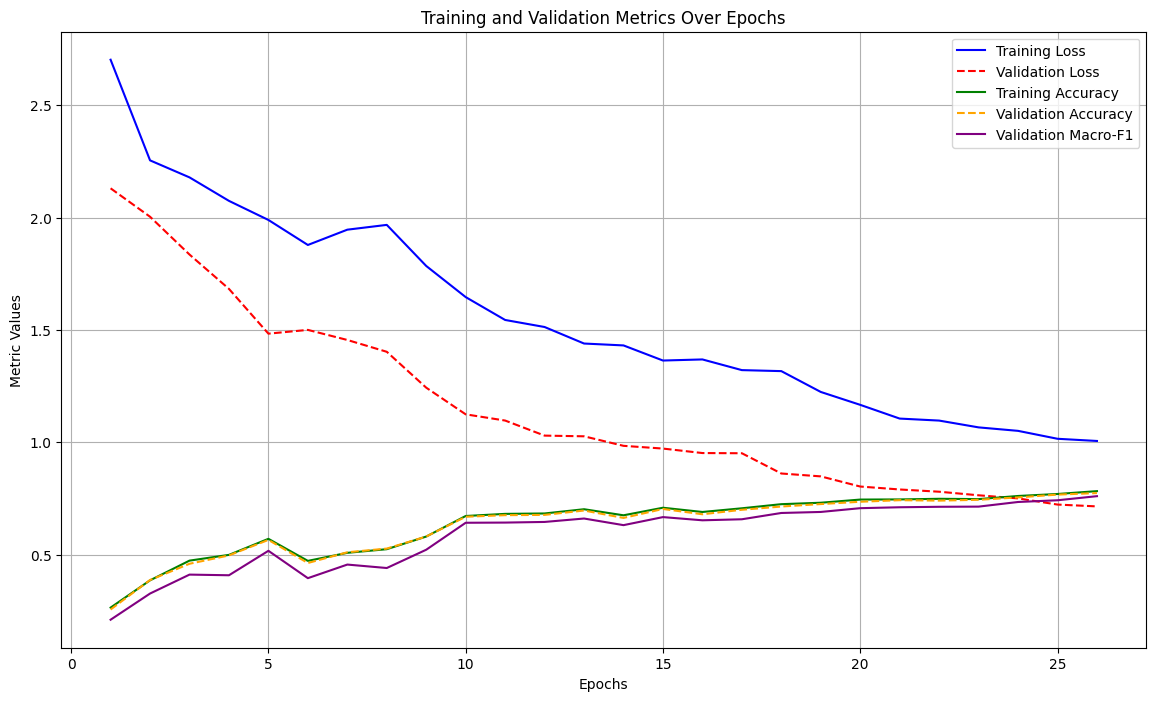

In [90]:
import matplotlib.pyplot as plt

# Function to plot all metrics on the same graph
def plot_metrics_over_epochs(training_losses, training_accuracies, validation_losses, validation_accuracies, validation_macro_f1_scores):
    epochs = range(1, len(training_losses) + 1)  # x-axis for epochs

    plt.figure(figsize=(14, 8))

    # Plot each metric
    plt.plot(epochs, training_losses, label='Training Loss', linestyle='-', color='blue')
    plt.plot(epochs, validation_losses, label='Validation Loss', linestyle='--', color='red')
    plt.plot(epochs, training_accuracies, label='Training Accuracy', linestyle='-', color='green')
    plt.plot(epochs, validation_accuracies, label='Validation Accuracy', linestyle='--', color='orange')
    plt.plot(epochs, validation_macro_f1_scores, label='Validation Macro-F1', linestyle='-', color='purple')

    # Title and labels
    plt.title('Training and Validation Metrics Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Values')
    plt.legend(loc='best')
    plt.grid(True)

    # Display the plot
    plt.show()

# Call the function with the recorded metrics
plot_metrics_over_epochs(
    training_losses=training_losses,
    training_accuracies=training_accuracies,
    validation_losses=validation_losses,
    validation_accuracies=validation_accuracies,
    validation_macro_f1_scores=validation_macro_f1_scores
)

# Metrics

Test Accuracy: 77.41%
Confusion Matrix:
 [[867   1   6  64  18   3  22   0  19   0]
 [ 10 941  15  30   1   0   1   0   2   0]
 [ 35   0 597  10 314   1  32   0  10   1]
 [ 69  10   6 857  40   1  13   0   4   0]
 [ 28   1  87  60 775   0  39   0   8   2]
 [  2   0   1   1   0 788   0 148  10  50]
 [343   0 114  38 331   1 139   0  33   1]
 [  1   0   0   0   0  22   0 904   1  72]
 [ 11   2   3   9   1   9  17   5 938   5]
 [  0   0   0   1   0  11   0  52   1 935]]


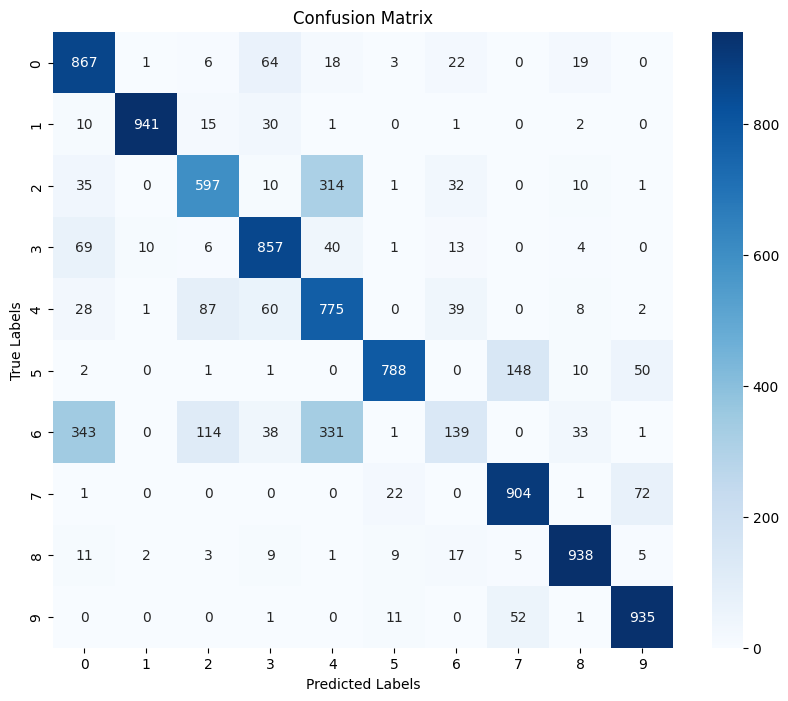


Weighted Precision: 0.77
Weighted Recall: 0.77
Weighted F1-Score: 0.76

Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.87      0.73      1000
           1       0.99      0.94      0.96      1000
           2       0.72      0.60      0.65      1000
           3       0.80      0.86      0.83      1000
           4       0.52      0.78      0.62      1000
           5       0.94      0.79      0.86      1000
           6       0.53      0.14      0.22      1000
           7       0.82      0.90      0.86      1000
           8       0.91      0.94      0.93      1000
           9       0.88      0.94      0.91      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.76     10000
weighted avg       0.77      0.77      0.76     10000



In [91]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

test_pred = neural_network.predict(test_features)
test_predicted_classes = np.argmax(test_pred, axis=1)

test_accuracy = np.mean(test_predicted_classes == test_targets) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")


conf_matrix = confusion_matrix(test_targets, test_predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_targets), yticklabels=np.unique(test_targets))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate and print weighted precision, recall, and F1-score

wt_precision = precision_score(test_targets, test_predicted_classes, average='weighted')
wt_f1 = f1_score(test_targets, test_predicted_classes, average='weighted')
wt_recall = recall_score(test_targets, test_predicted_classes, average='weighted')


print(f"\nWeighted Precision: {wt_precision:.2f}")
print(f"Weighted Recall: {wt_recall:.2f}")
print(f"Weighted F1-Score: {wt_f1:.2f}")

# Detailed classification report (includes all metrics including macro and weighted averages)
print("\nClassification Report:\n")
print(classification_report(test_targets, test_predicted_classes))

# Saving the model

In [92]:
from google.colab import drive
import pickle

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/model_weights.pkl'

weights = neural_network.get_weights()  # Adjust this according to how weights are stored in your class

# Save only the weights to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(weights, file)

print("Neural network weights saved to neural_network_weights.pkl in Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Neural network weights saved to neural_network_weights.pkl in Google Drive


# Loading the model to check performance

In [93]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import numpy as np
import pickle

# Define the new neural network instance
neural_network_test = NeuralNetwork(
    number_of_layers=number_of_layers,  # Replace with actual number of layers
    neurons_in_each_layer=neurons_in_each_layer,  # Replace with actual array of neurons per layer
    input_dimensions=input_dimensions,  # Replace with actual input dimensions
    number_of_classes=number_of_classes,  # Replace with actual number of classes
    dropout_rate=d_rate  # Replace with actual dropout rate if different
)

# Load weights from a pickle file
weights_file_path = '/content/drive/My Drive/model_weights.pkl'

with open(weights_file_path, 'rb') as file:
    loaded_weights = pickle.load(file)

# Load the weights into the newly defined neural network
neural_network_test.load_weights(loaded_weights)

# Perform predictions and evaluate
test_pred = neural_network_test.predict(test_features)
test_predicted_classes = np.argmax(test_pred, axis=1)

# Calculate test accuracy
test_accuracy = np.mean(test_predicted_classes == test_targets) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_targets, test_predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Calculate and print weighted precision, recall, and F1-score
wt_precision = precision_score(test_targets, test_predicted_classes, average='weighted')
wt_f1 = f1_score(test_targets, test_predicted_classes, average='weighted')
wt_recall = recall_score(test_targets, test_predicted_classes, average='weighted')

print(f"\nWeighted Precision: {wt_precision:.2f}")
print(f"Weighted Recall: {wt_recall:.2f}")
print(f"Weighted F1-Score: {wt_f1:.2f}")

# Print detailed classification report
print("\nClassification Report:\n")
print(classification_report(test_targets, test_predicted_classes))

Weights loaded successfully into the network.
Test Accuracy: 71.01%
Confusion Matrix:
 [[904   1  15  39   7   2   3   0  24   5]
 [ 17 936  16  28   0   0   1   0   2   0]
 [ 92   0 616   6 178   0  85   0  15   8]
 [160  10  27 788   7   0   2   0   4   2]
 [167   1 108  23 250   0 436   0   7   8]
 [  1   0   5   1   0 614   0 301  12  66]
 [529   0 151  19  63   5 188   1  37   7]
 [  0   0   0   0   0   8   0 922   2  68]
 [ 16   2   6   8   2   4   0   5 947  10]
 [  0   0   2   0   0   2   0  59   1 936]]

Weighted Precision: 0.72
Weighted Recall: 0.71
Weighted F1-Score: 0.70

Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.90      0.63      1000
           1       0.99      0.94      0.96      1000
           2       0.65      0.62      0.63      1000
           3       0.86      0.79      0.82      1000
           4       0.49      0.25      0.33      1000
           5       0.97      0.61      0.75      1000
      

# Online task

Weights loaded successfully into the network.
Images shape: (3611, 1, 28, 28)
Labels shape: (3611,)


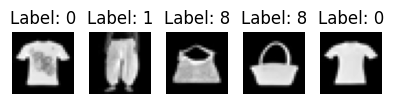

Number of possible classifications: 4
Test Accuracy: 0.37%

Confusion Matrix:
 [[305   4   4  88   5   1   2   0  49 196]
 [ 13 432   0  38   1   0   0   0   0  11]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  4   0   0  34  12  84   5 647  16  51]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [ 52   3 289 160 242 208  71   8 520  56]
 [  0   0   0   0   0   0   0   0   0   0]]

Weighted Precision: 0.75
Weighted Recall: 0.37
Weighted F1-Score: 0.48

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.47      0.59       654
           1       0.98      0.87      0.93       495
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.29      0.10      0.15       853
           6  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

In [94]:
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import torch

# Step 1: Load the pre-trained weights from the pkl file
with open('/content/drive/My Drive/model_weights.pkl', 'rb') as file:
    loaded_weights = pickle.load(file)

# Initialize the FNN and load the weights
neural_network.load_weights(loaded_weights)

# Step 2: Load the test set from the pkl file
with open('a2.pkl', 'rb') as file:
    test_data = pickle.load(file)
# Check if the test_data is a TensorDataset and extract data
if isinstance(test_data, torch.utils.data.dataset.TensorDataset):
    test_images, test_labels = test_data.tensors
    test_images = test_images.numpy()  # Convert to numpy array
    test_labels = test_labels.numpy()  # Convert to numpy array
    print(f"Images shape: {test_images.shape}")
    print(f"Labels shape: {test_labels.shape}")

    # Display 5 images and their corresponding labels
    plt.figure(figsize=(4, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(test_images[i].squeeze(), cmap='gray')  # Remove extra dimension
        plt.title(f"Label: {test_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print the number of possible classifications in the dataset
    num_classes = len(np.unique(test_labels))
    print(f"Number of possible classifications: {num_classes}")

else:
    print("The dataset format is not as expected. Please check the file structure.")


# Step 3: Preprocess the test images (flatten and scale)
test_images_reshaped = test_images.reshape(test_images.shape[0], 28 * 28)

# Load the scaler used during training
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Apply the same scaling as used during training
test_features = scaler.transform(test_images_reshaped)

# Step 4: Use the FNN to predict classifications
test_predictions = neural_network.predict(test_features)
predicted_classes = np.argmax(test_predictions, axis=1)

# Calculate and display accuracy
accuracy = accuracy_score(test_labels, predicted_classes)
print(f"Test Accuracy: {accuracy:.2f}%")

# Display the confusion matrix and classification report
conf_matrix = confusion_matrix(test_labels, predicted_classes)
print("\nConfusion Matrix:\n", conf_matrix)

# Print additional metrics
precision = precision_score(test_labels, predicted_classes, average='weighted')
recall = recall_score(test_labels, predicted_classes, average='weighted')
f1 = f1_score(test_labels, predicted_classes, average='weighted')

print(f"\nWeighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1-Score: {f1:.2f}")

print("\nClassification Report:\n")
print(classification_report(test_labels, predicted_classes))